In [4]:
import cv2
import numpy as np
import matplotlib.pyplot as plt


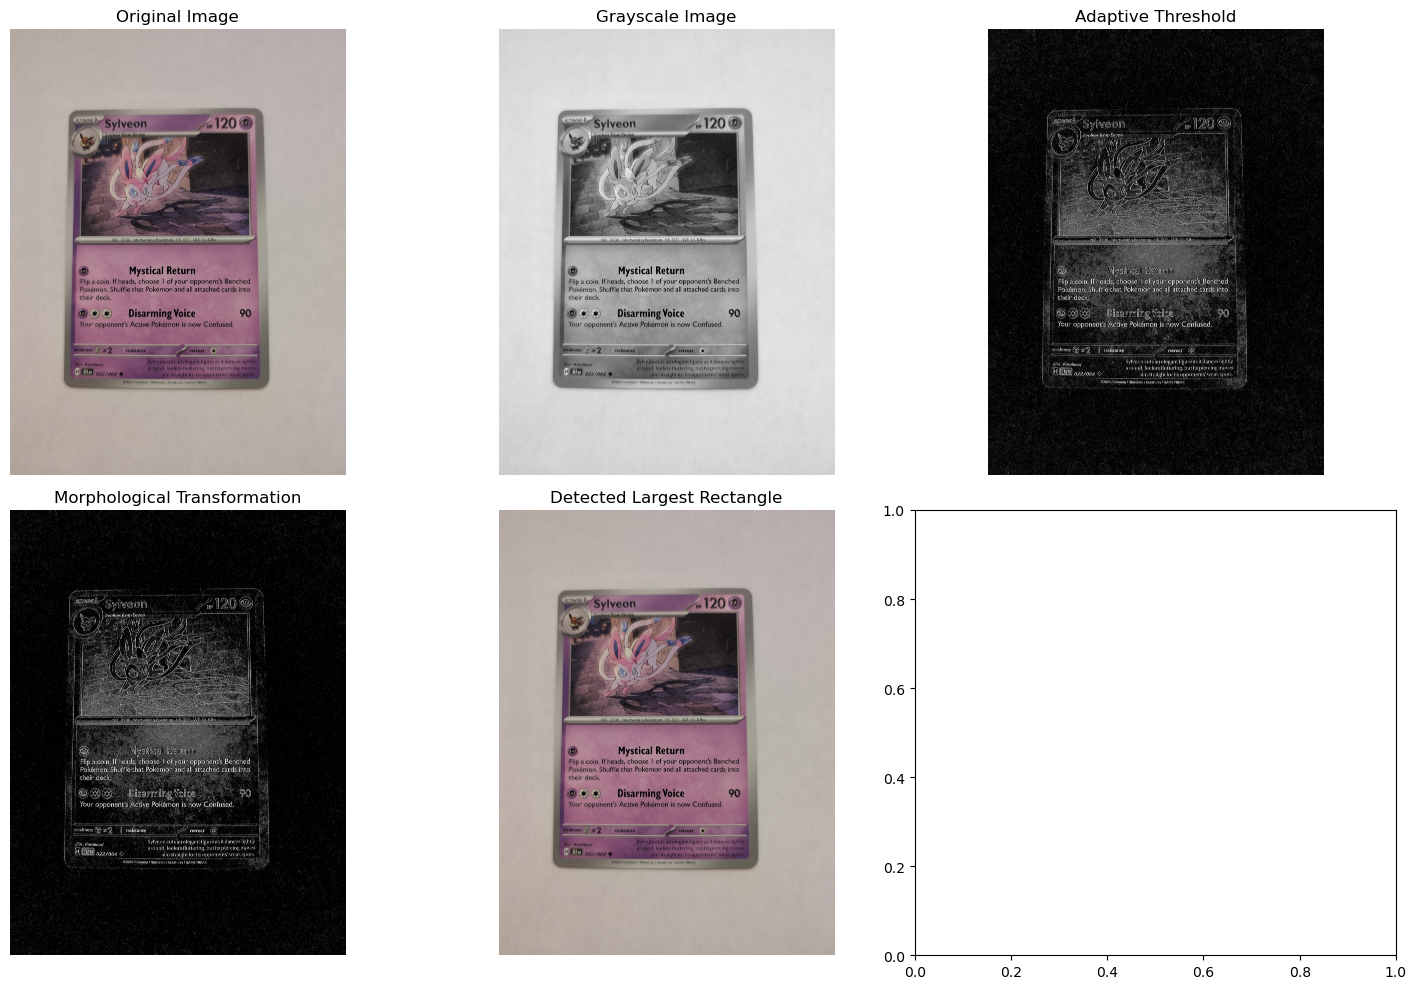

In [45]:
# Load the image
image_path = r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\PXL_20240917_235346978.RAW-01.COVER.jpg'
image = cv2.imread(image_path)


# Check if the image was successfully loaded
if image is None:
    print(f"Error: Could not load image from {image_path}. Please check the file path.")
else:
    # Convert image to grayscale
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    
    # Apply Gaussian blur
    blurred = cv2.GaussianBlur(gray, (5, 5), 0)
    
    # Apply adaptive threshold
    adaptive_thresh = cv2.adaptiveThreshold(
        blurred, 
        255,
        cv2.ADAPTIVE_THRESH_GAUSSIAN_C
        cv2.THRESH_BINARY_INV,
        11,
        2 
    )

    # Apply morphological operations to enhance contours
    kernel = np.ones((2, 2), np.uint8)
    morphed = cv2.morphologyEx(adaptive_thresh, cv2.MORPH_CLOSE, kernel)
    
    # Apply morphological opening to remove small noise
    morphed = cv2.morphologyEx(morphed, cv2.MORPH_OPEN, kernel)

    # Find contours
    contours, _ = cv2.findContours(morphed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

    # Aspect ratio range
    desired_ratio = 2.5 / 3.5
    tolerance = 0.2 

    # Minimum contour area set to a large size
    image_area = image.shape[0] * image.shape[1]
    min_area = image_area / 2

    # Filter and sort contours by area
    filtered_contours = []
    for cnt in contours:
        # Get the bounding rectangle
        x, y, w, h = cv2.boundingRect(cnt)
        aspect_ratio = w / h
        rect_area = w * h

        # Check aspect ratio and size
        if abs(aspect_ratio - desired_ratio) <= tolerance and rect_area >= min_area:
            filtered_contours.append(cnt)

    # Sort contours by area in descending order
    filtered_contours = sorted(filtered_contours, key=cv2.contourArea, reverse=True)

    # Draw the largest contour if it exists
    image_with_rectangles = image.copy()
    if filtered_contours:
        # Draw the largest detected rectangle
        largest_contour = filtered_contours[0]
        x, y, w, h = cv2.boundingRect(largest_contour)
        cv2.rectangle(image_with_rectangles, (x, y), (x + w, y + h), (0, 255, 0), 3)

    # Convert images to RGB for displaying
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    image_with_rectangles_rgb = cv2.cvtColor(image_with_rectangles, cv2.COLOR_BGR2RGB)
    
    # Plot all the steps
    fig, axs = plt.subplots(2, 3, figsize=(15, 10))
    
    # Original Image
    axs[0, 0].imshow(image_rgb)
    axs[0, 0].set_title('Original Image')
    axs[0, 0].axis('off')
    
    # Grayscale Image
    axs[0, 1].imshow(gray, cmap='gray')
    axs[0, 1].set_title('Grayscale Image')
    axs[0, 1].axis('off')
    
    # Adaptive Threshold Image
    axs[0, 2].imshow(adaptive_thresh, cmap='gray')
    axs[0, 2].set_title('Adaptive Threshold')
    axs[0, 2].axis('off')
    
    # Morphological Transformation
    axs[1, 0].imshow(morphed, cmap='gray')
    axs[1, 0].set_title('Morphological Transformation')
    axs[1, 0].axis('off')
    
    # Final Image with Largest Rectangle
    axs[1, 1].imshow(image_with_rectangles_rgb)
    axs[1, 1].set_title('Detected Largest Rectangle')
    axs[1, 1].axis('off')
    
    plt.tight_layout()
    plt.show()

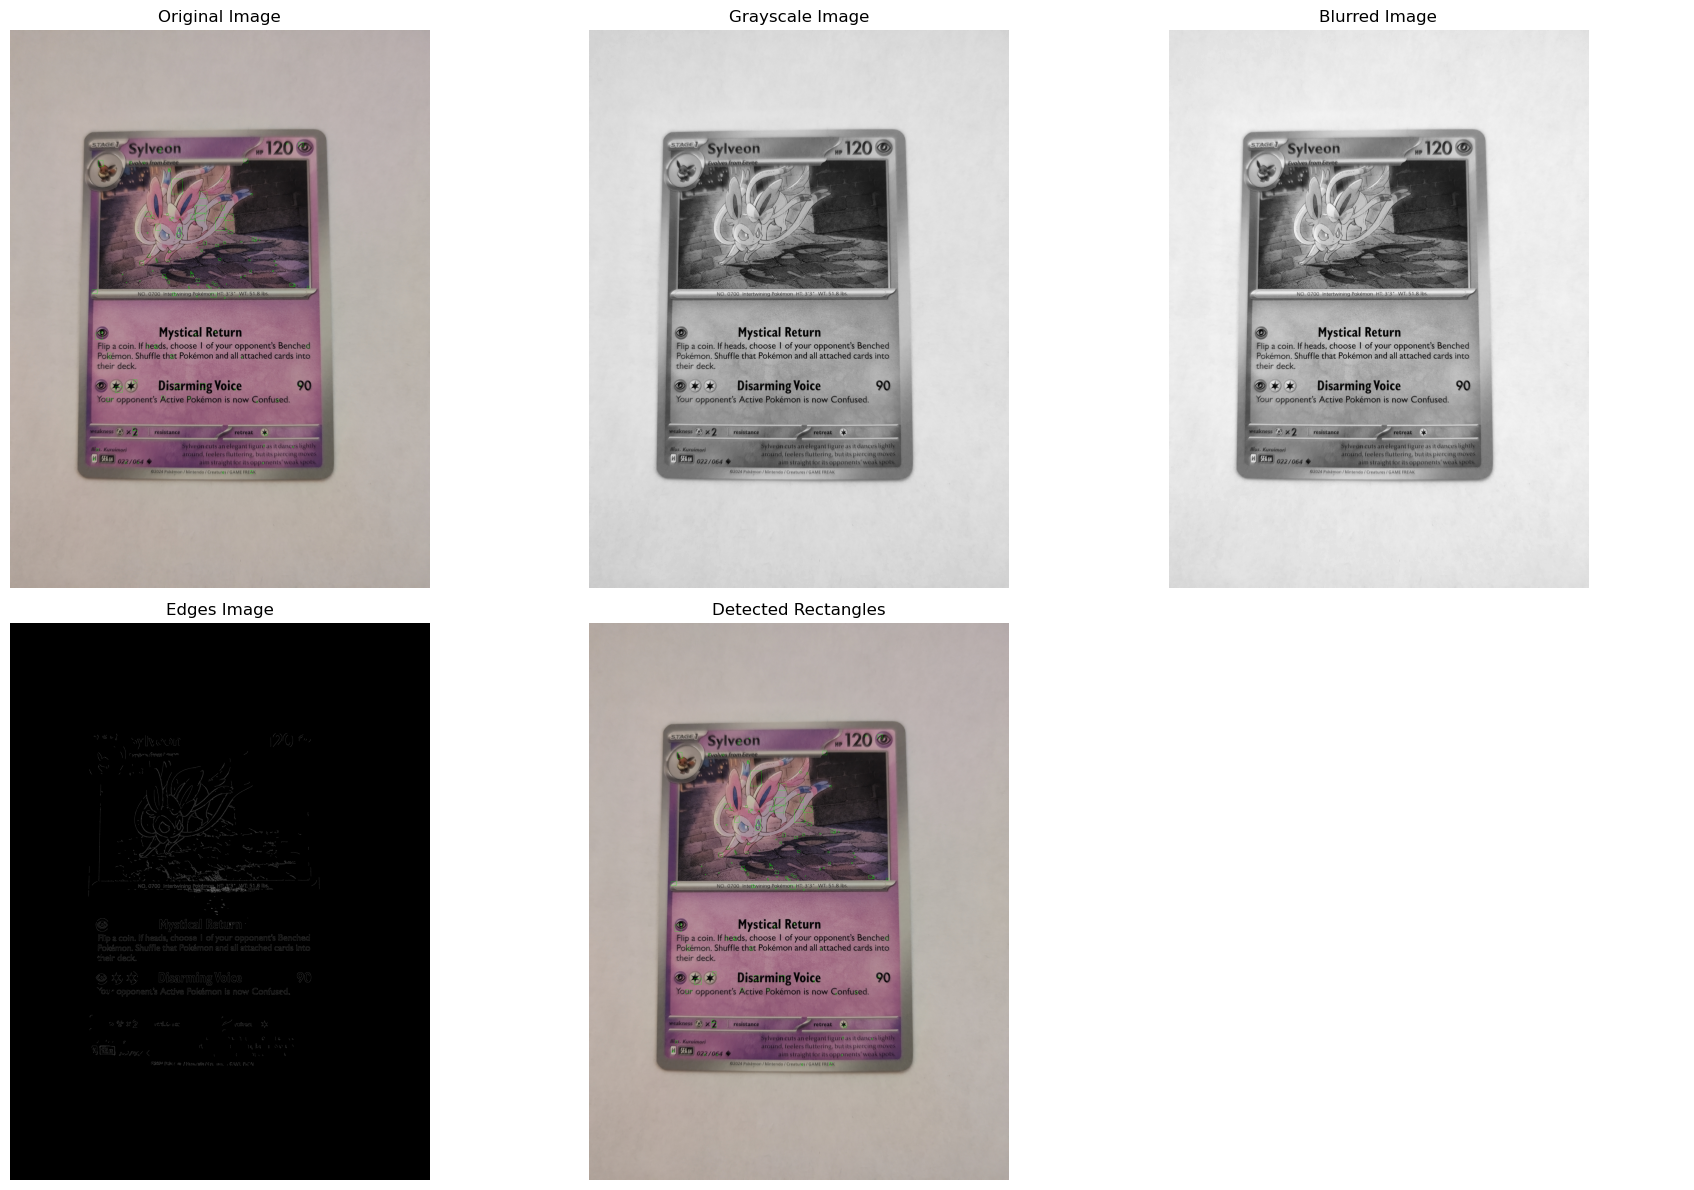

In [50]:
# Get image dimensions
image_height, image_width = image.shape[:2]
total_image_area = image_width * image_height

# Preprocess the image
gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
blurred = cv2.GaussianBlur(gray, (5, 5), 0)
edges = cv2.Canny(blurred, 50, 150)

# Find contours
contours, _ = cv2.findContours(edges, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Function to check if the contour is a rectangle with the desired aspect ratio and area
def is_significant_rectangle(cnt, min_ratio, max_ratio, min_area_ratio):
    epsilon = 0.02 * cv2.arcLength(cnt, True)
    approx = cv2.approxPolyDP(cnt, epsilon, True)
    
    if len(approx) == 4:
        x, y, w, h = cv2.boundingRect(approx)
        aspect_ratio = float(w) / h if h != 0 else 0
        area = w * h
        is_aspect_ratio_valid = min_ratio <= aspect_ratio <= max_ratio
        is_area_valid = area > min_area_ratio * total_image_area
        return is_aspect_ratio_valid and is_area_valid
    return False

# Define the desired aspect ratio range and minimum area ratio
min_ratio = 2.5 / 3.5
max_ratio = 3.5 / 2.5
min_area_ratio = 0.50 

# Draw rectangles on the image
image_with_rectangles_rgb = image_rgb.copy()
for contour in contours:
    if is_significant_rectangle(contour, min_ratio, max_ratio, min_area_ratio):
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(image_with_rectangles_rgb, (x, y), (x+w, y+h), (0, 255, 0), 2)

# Plot all images in a grid
fig, axs = plt.subplots(2, 3, figsize=(18, 12))

# Original Image
axs[0, 0].imshow(image_rgb)
axs[0, 0].set_title('Original Image')
axs[0, 0].axis('off')

# Grayscale Image
axs[0, 1].imshow(gray, cmap='gray')
axs[0, 1].set_title('Grayscale Image')
axs[0, 1].axis('off')

# Blurred Image
axs[0, 2].imshow(blurred, cmap='gray')
axs[0, 2].set_title('Blurred Image')
axs[0, 2].axis('off')

# Edges Image
axs[1, 0].imshow(edges, cmap='gray')
axs[1, 0].set_title('Edges Image')
axs[1, 0].axis('off')

# Final Result with Detected Rectangles
axs[1, 1].imshow(image_with_rectangles_rgb)
axs[1, 1].set_title('Detected Rectangles')
axs[1, 1].axis('off')

# Remove empty subplot (if needed)
axs[1, 2].axis('off')

plt.tight_layout()
plt.show()

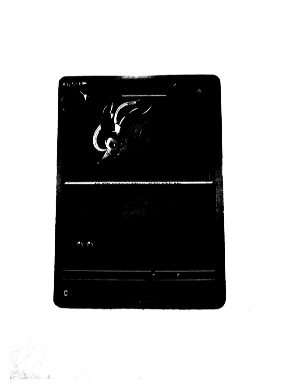

In [12]:
from PIL import Image
import matplotlib.pyplot as plt

# Open the image
image = Image.open(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\PXL_20240917_235346978.RAW-01.COVER.jpg')

# Convert the image to RGB format
image = image.convert('RGB')

# Set the threshold for how close to white a color should be
threshold = 150

# Define the white and black colors
white = (255, 255, 255)
black = (0, 0, 0)

# Load the image data
pixels = image.load()

# Get image dimensions
width, height = image.size

# Loop through all pixels
for x in range(width):
    for y in range(height):
        r, g, b = pixels[x, y]
        
        # Check if the color is close to white
        if r > threshold and g > threshold and b > threshold:
            pixels[x, y] = white
        else:
            pixels[x, y] = black

# Display the modified image
plt.imshow(image)
plt.axis('off')
plt.show()

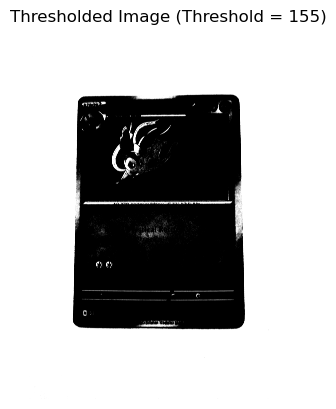

In [15]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image using OpenCV
image = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\PXL_20240917_235346978.RAW-01.COVER.jpg')

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Apply a threshold to turn non-white pixels to black
threshold_value = 155
_, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

# Display the thresholded image using matplotlib
plt.imshow(thresholded, cmap='gray')
plt.title(f"Thresholded Image (Threshold = {threshold_value})")
plt.axis('off')  # Hide the axis
plt.show()

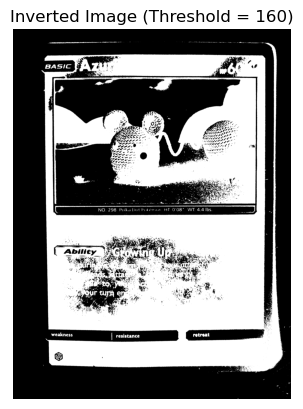

Number of contours found: 769


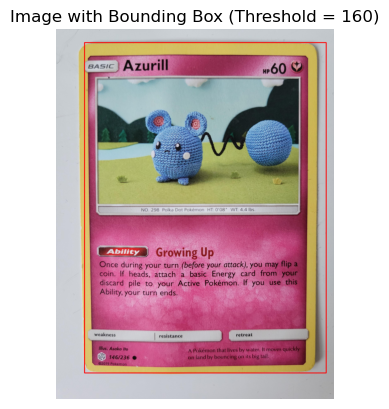

In [48]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

# Load the image using OpenCV
image = cv2.imread(r'C:\Users\Jimmy\Desktop\cb-ds-19\00_Projects\ds-final-project-main\Test Image\azurill.jpg')

# Convert the image to RGB
image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# Convert the image to grayscale
gray = cv2.cvtColor(image_rgb, cv2.COLOR_RGB2GRAY)

# Apply a threshold to turn non-white pixels to black
threshold_value = 160
_, thresholded = cv2.threshold(gray, threshold_value, 255, cv2.THRESH_BINARY)

# Invert the binary image so that black object becomes white and background becomes black
inverted = cv2.bitwise_not(thresholded)

# Display the inverted image to confirm inversion worked
plt.imshow(inverted, cmap='gray')
plt.title(f"Inverted Image (Threshold = {threshold_value})")
plt.axis('off')
plt.show()

# Find contours of the black object in the inverted image
contours, _ = cv2.findContours(inverted, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)

# Check if any contours were found
if contours:
    print(f"Number of contours found: {len(contours)}")

    # Find the largest contour (assuming object is the largest)
    largest_contour = max(contours, key=cv2.contourArea)
    x, y, w, h = cv2.boundingRect(largest_contour)
    
    # Draw the bounding box on the original image
    cv2.rectangle(image_rgb, (x, y), (x + w, y + h), (255, 0, 0), 7)

    # Display the original image with bounding box
    plt.imshow(image_rgb)
    plt.title(f"Image with Bounding Box (Threshold = {threshold_value})")
    plt.axis('off')
    plt.show()
else:
    print("No contours were found.")
